In [ ]:
import json
import folium

# Načítaj prvých 5 jázd zo súboru
drives = []
with open("synteticke_json_jazdy_final.jsonl", "r") as f:
    for i, line in enumerate(f):
        drives.append(json.loads(line))
        if i >= 4:
            break

# Vytvor mapu - začiatok nastav na priemer prvej jazdy
first_drive_coords = [
    tuple(map(float, rec['v'].split(',')))
    for rec in drives[0]['records'] if rec['n'] == 'PERSONALIZED_LOCATION'
]
center_lat = sum(c[0] for c in first_drive_coords) / len(first_drive_coords)
center_lon = sum(c[1] for c in first_drive_coords) / len(first_drive_coords)

m = folium.Map(location=[center_lat, center_lon], zoom_start=10)

# Prekresli jednotlivé trasy
colors = ["red", "blue", "green", "purple", "orange"]

for idx, drive in enumerate(drives):
    coords = [
        tuple(map(float, rec['v'].split(',')))
        for rec in drive['records'] if rec['n'] == 'PERSONALIZED_LOCATION'
    ]
    folium.PolyLine(coords, color=colors[idx % len(colors)], weight=3, opacity=0.7).add_to(m)
    folium.Marker(coords[0], icon=folium.Icon(color='green'), popup='Štart').add_to(m)
    folium.Marker(coords[-1], icon=folium.Icon(color='red'), popup='Cieľ').add_to(m)

# Zobraz mapu
m.save("mapa_jazd.html")
print("✅ Vizualizácia hotová. Otvor súbor mapa_jazd.html v prehliadači.")


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Premena raw records na dataframe
records_df = pd.DataFrame(records)
records_df['t'] = pd.to_datetime(records_df['t'], unit='s')
records_df['v'] = pd.to_numeric(records_df['v'], errors='coerce')
pivot = records_df.pivot(index='t', columns='n', values='v')

# Vizualizácia
pivot[['SPEED', 'LONGITUDINAL_ACCELERATION', 'LATERAL_ACCELERATION']].plot(figsize=(12,6))
plt.title("Vývoj rýchlosti a zrýchlení v čase")
plt.xlabel("Čas")
plt.ylabel("Hodnota")
plt.grid()
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import json
import folium

# Načítanie súboru
file_path = "synteticke_json_jazdy_enriched_full_osm4.jsonl"
with open(file_path, "r", encoding="utf-8") as f:
    data = [json.loads(line) for line in f if line.strip()]

# Pripravený zoznam bodov s incidentmi
incident_points_all = []

# Spracovanie každej jazdy
for jazda in data:
    records = jazda["records"]
    records_df = pd.DataFrame(records)

    # GPS súradnice
    loc_df = records_df[(records_df["n"] == "PERSONALIZED_LOCATION") & 
                        (records_df["v"].astype(str).str.contains(","))].copy()
    if loc_df.empty:
        continue

    latlon = loc_df["v"].str.split(",", expand=True)
    loc_df["lat"] = pd.to_numeric(latlon[0], errors="coerce")
    loc_df["lon"] = pd.to_numeric(latlon[1], errors="coerce")
    loc_df["t"] = pd.to_datetime(loc_df["t"], unit="s")
    loc_df = loc_df.dropna(subset=["lat", "lon"])

    # Incidenty
    incident_df = records_df[(records_df["n"] == "INCIDENT") & (records_df["v"].astype(str) == "1")].copy()
    incident_df["t"] = pd.to_datetime(incident_df["t"], unit="s")

    # Vyhľadanie najbližšieho bodu ku každému incidentu
    for t in incident_df["t"]:
        if not loc_df.empty:
            nearest = loc_df.iloc[(loc_df["t"] - t).abs().argsort()[:1]]
            incident_points_all.append(nearest)

# Vykreslenie mapy
if incident_points_all:
    incident_points_df = pd.concat(incident_points_all)
    m = folium.Map(location=[incident_points_df["lat"].mean(), incident_points_df["lon"].mean()], zoom_start=13)

    for _, row in incident_points_df.iterrows():
        folium.CircleMarker(location=[row["lat"], row["lon"]],
                            radius=5,
                            color='red',
                            fill=True,
                            popup="Incident").add_to(m)

    m.save("incident_map.html")
    print("✔️ Mapa incidentov bola vygenerovaná ako 'incident_map.html'")
else:
    print("❗ Neboli nájdené žiadne incidenty so súradnicami.")


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import json

# --- Načítanie dát ---
with open("synteticke_json_jazdy_enriched_full_osm4.jsonl", "r", encoding="utf-8") as f:
    data = [json.loads(line) for line in f if line.strip()]

# Vyber index jazdy, ktorú chceš vizualizovať
index_jazdy = 0
jazda = data[index_jazdy]
records_df = pd.DataFrame(jazda["records"])

# --- Príprava dát ---
records_df["t"] = pd.to_datetime(records_df["t"], unit="s")
wide = records_df.pivot(index="t", columns="n", values="v").apply(pd.to_numeric, errors="coerce")

# --- Vizualizácia: rýchlosť a incidenty ---
fig, ax1 = plt.subplots(figsize=(12, 5))

ax1.plot(wide.index, wide["SPEED"], label="Rýchlosť [km/h]", color="blue")
ax1.set_ylabel("Rýchlosť", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# Incidenty – zvýrazni ako červené body
incident_times = wide[wide["INCIDENT"] == 1].index
incident_speeds = wide.loc[incident_times, "SPEED"]
ax1.scatter(incident_times, incident_speeds, color="red", label="Incident", zorder=5)

plt.title(f"Časový priebeh rýchlosti a incidentov – jazda č. {index_jazdy}")
plt.xlabel("Čas")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- Zrýchlenia ---
wide[["LONGITUDINAL_ACCELERATION", "LATERAL_ACCELERATION"]].plot(figsize=(12, 4))
plt.title(f"Časový priebeh zrýchlení – jazda č. {index_jazdy}")
plt.xlabel("Čas")
plt.ylabel("Zrýchlenie [m/s²]")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

# Načítaj dáta
df = pd.read_csv("kompletne_metriky_jazd.csv")

# Výpočet safety_score ak chýba
if "safety_score" not in df.columns:
    risk_features = ['hard_accels', 'hard_brakes', 'overspeed_count',
                     'volatility', 'direction_changes', 'std_speed']
    weights = {
        'hard_accels': 0.18, 'hard_brakes': 0.18, 'overspeed_count': 0.12,
        'volatility': 0.18, 'direction_changes': 0.17, 'std_speed': 0.17
    }
    scaler = MinMaxScaler()
    norm = scaler.fit_transform(df[risk_features])
    norm_df = pd.DataFrame(norm, columns=risk_features)
    df['risk_score'] = sum(norm_df[feat] * w for feat, w in weights.items())
    df['safety_score'] = (1 - df['risk_score']).clip(0, 1) * 100

# Výber vstupov bez kolineárnych atribútov
features = [
    'hard_accels', 'avg_jerk', 'volatility', 'max_speed',
    'overspeed_count', 'distance_m', 'precipitation', 'visibility', 'temperature'
]

df_model = df.dropna(subset=features + ['safety_score'])

X = df_model[features]
y = df_model['safety_score']

# Definuj metriky
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
r2_scorer = make_scorer(r2_score)

# Modely
models = {
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "LinearRegression": LinearRegression(),
    "SVR": SVR(),
    "KNN": KNeighborsRegressor()
}

# Krížová validácia
cv = KFold(n_splits=5, shuffle=True, random_state=42)
results = []

for name, model in models.items():
    rmse_scores = -cross_val_score(model, X, y, cv=cv, scoring=rmse_scorer)
    mae_scores = -cross_val_score(model, X, y, cv=cv, scoring=mae_scorer)
    r2_scores = cross_val_score(model, X, y, cv=cv, scoring=r2_scorer)

    results.append({
        "Model": name,
        "Avg_RMSE": rmse_scores.mean(),
        "Avg_MAE": mae_scores.mean(),
        "Avg_R2": r2_scores.mean()
    })

# Výsledky ako tabuľka
cv_results = pd.DataFrame(results).sort_values("Avg_R2", ascending=False)
print(cv_results)


In [ ]:
import json
import pandas as pd
from collections import defaultdict

input_path = "synteticke_json_jazdy_enriched_full_osm4.jsonl"

# Príprava štruktúr
drives_by_driver = defaultdict(list)

# Načítanie a rozdelenie jázd podľa typu vodiča
with open(input_path, "r", encoding="utf-8") as f:
    for line in f:
        drive = json.loads(line)
        driver_type = drive.get("driverType", "nezadaný")
        drives_by_driver[driver_type].append(drive)

# Výpočet štatistiky pre každého vodiča
def compute_stats(drive_group):
    rows = []
    for drive in drive_group:
        records = drive["records"]
        acc = [float(r["v"]) for r in records if r["n"] == "LONGITUDINAL_ACCELERATION"]
        lat_acc = [abs(float(r["v"])) for r in records if r["n"] == "LATERAL_ACCELERATION"]
        speed = [float(r["v"]) for r in records if r["n"] == "SPEED"]
        tmin = min(r["t"] for r in records)
        tmax = max(r["t"] for r in records)
        duration = (tmax - tmin) / 60
        incidents = [r for r in records if r["n"] == "INCIDENT" and r["v"] == "1"]
        severities = [r.get("incident_severity", "unknown") for r in incidents]
        rows.append({
            "duration_min": duration,
            "min_speed": min(speed) if speed else None,
            "max_speed": max(speed) if speed else None,
            "stop_and_go": sum(1 for r in records if r["n"] == "SPEED" and float(r["v"]) < 5),
            "hard_braking": sum(1 for a in acc if a < -3),
            "hard_acceleration": sum(1 for a in acc if a > 3),
            "lateral_risk": sum(1 for a in lat_acc if a > 2.5),
            "incident_count": len(incidents),
            "incident_low": severities.count("low"),
            "incident_medium": severities.count("medium"),
            "incident_high": severities.count("high")
        })
    df = pd.DataFrame(rows)
    return {
        "Počet jázd": len(drive_group),
        "Priemerné trvanie (min)": round(df["duration_min"].mean(), 2),
        "Priemerná min. rýchlosť (km/h)": round(df["min_speed"].mean(), 2),
        "Priemerná max. rýchlosť (km/h)": round(df["max_speed"].mean(), 2),
        "Priemerný počet stop&go": round(df["stop_and_go"].mean(), 2),
        "Priemerné prudké brzdenia": round(df["hard_braking"].mean(), 2),
        "Priemerné prudké akcelerácie": round(df["hard_acceleration"].mean(), 2),
        "Priemerné laterálne manévre": round(df["lateral_risk"].mean(), 2),
        "Priemerný počet incidentov": round(df["incident_count"].mean(), 2),
        "Incidenty nízkej závažnosti": round(df["incident_low"].mean(), 2),
        "Incidenty strednej závažnosti": round(df["incident_medium"].mean(), 2),
        "Incidenty vysokej závažnosti": round(df["incident_high"].mean(), 2)
    }

# Výpočet a zobrazenie pre každý typ vodiča
print("\n📊 Rozšírená štatistika podľa typu vodiča:\n")
for driver_type, group in drives_by_driver.items():
    print(f"\n👤 Vodič: {driver_type}")
    result = compute_stats(group)
    for k, v in result.items():
        print(f"{k}: {v}")


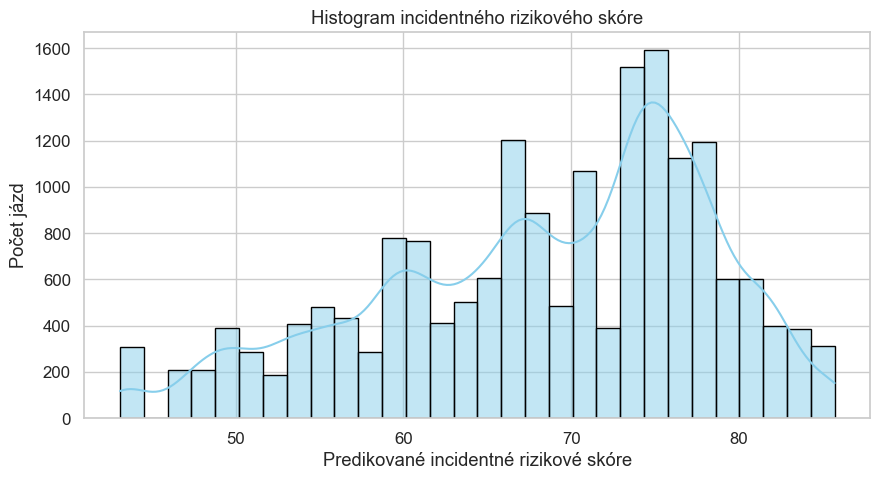

C:\Users\Kristián\AppData\Local\Temp\ipykernel_33652\2044414665.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="part_of_day", y="predicted_incident_risk_score", palette="pastel")


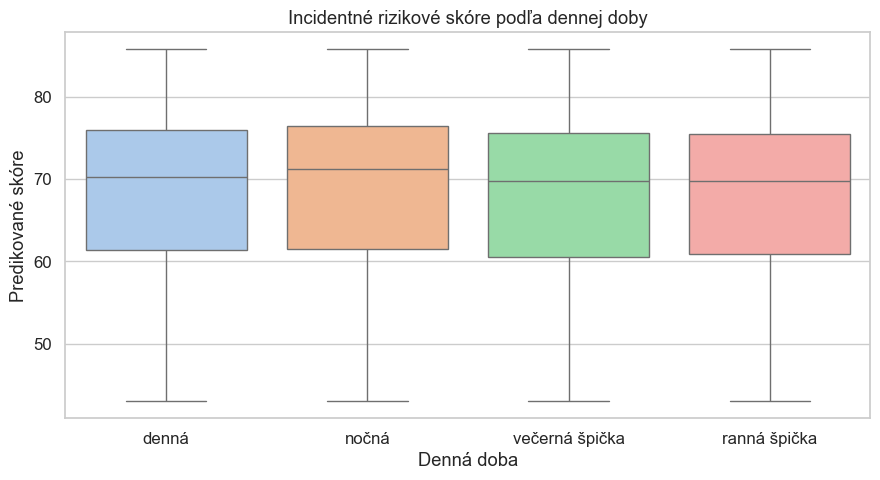

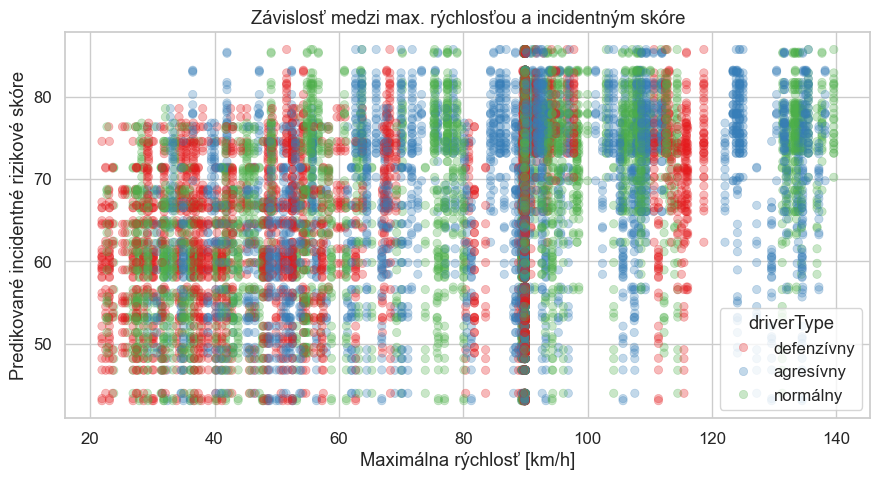

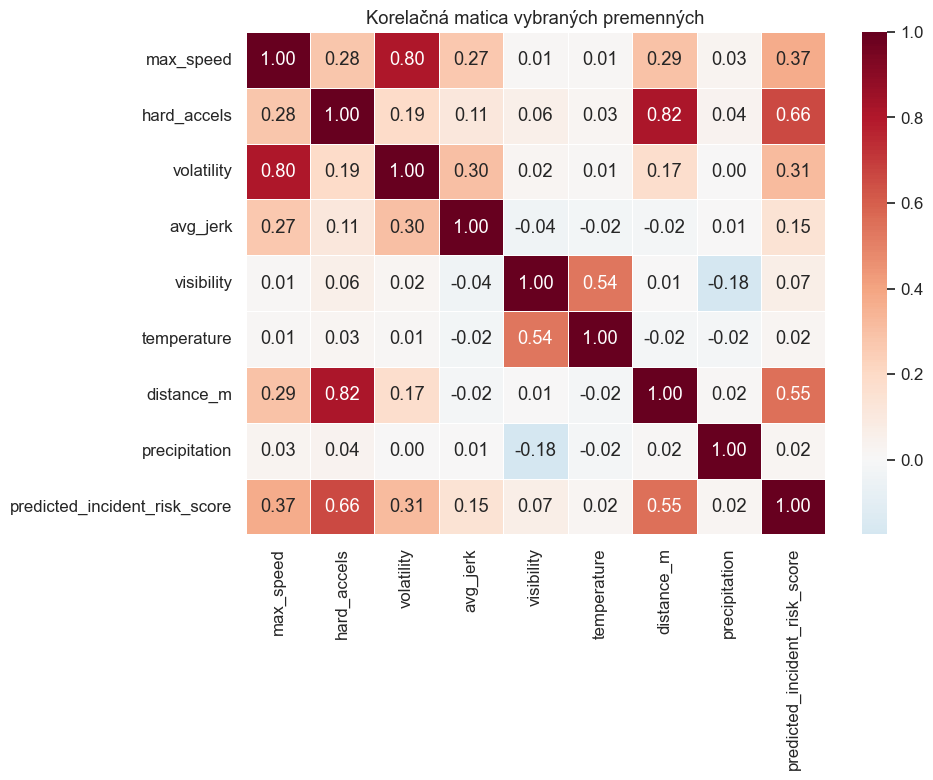

C:\Users\Kristián\AppData\Local\Temp\ipykernel_33652\2044414665.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="driverType", y="predicted_incident_risk_score", palette="muted")


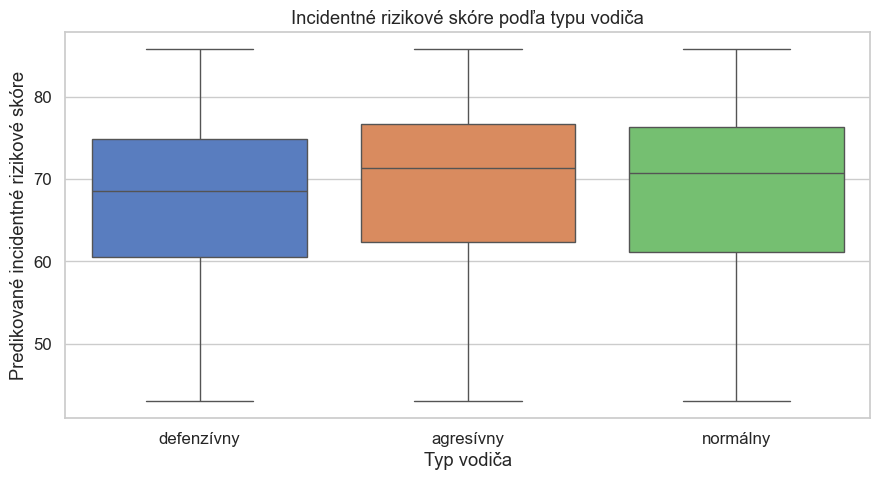

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Nastavenie štýlu
sns.set(style="whitegrid", font_scale=1.1)

# Načítanie dát
df = pd.read_csv("jazdy_ai_skore_randomforest_full_enriched.csv")

# 1. Histogram incidentného rizikového skóre
plt.figure(figsize=(9, 5))
sns.histplot(df["predicted_incident_risk_score"], bins=30, kde=True, color="skyblue", edgecolor="black")
plt.title("Histogram incidentného rizikového skóre")
plt.xlabel("Predikované incidentné rizikové skóre")
plt.ylabel("Počet jázd")
plt.tight_layout()
plt.show()

# 2. Boxplot podľa dennej doby
plt.figure(figsize=(9, 5))
sns.boxplot(data=df, x="part_of_day", y="predicted_incident_risk_score", palette="pastel")
plt.title("Incidentné rizikové skóre podľa dennej doby")
plt.xlabel("Denná doba")
plt.ylabel("Predikované skóre")
plt.tight_layout()
plt.show()

# 3. Scatterplot: max speed vs incident score
plt.figure(figsize=(9, 5))
sns.scatterplot(data=df, x="max_speed", y="predicted_incident_risk_score", hue="driverType", palette="Set1", alpha=0.3, edgecolor=None)
plt.title("Závislosť medzi max. rýchlosťou a incidentným skóre")
plt.xlabel("Maximálna rýchlosť [km/h]")
plt.ylabel("Predikované incidentné rizikové skóre")
plt.tight_layout()
plt.show()

# 4. Korelačná matica vybraných premenných
selected = ['max_speed', 'hard_accels', 'volatility', 'avg_jerk', 'visibility', 'temperature',
            'distance_m', 'precipitation', 'predicted_incident_risk_score']
corr = df[selected].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="RdBu_r", center=0, fmt=".2f", linewidths=0.5)
plt.title("Korelačná matica vybraných premenných")
plt.tight_layout()
plt.show()

# 5. Boxplot podľa typu vodiča
plt.figure(figsize=(9, 5))
sns.boxplot(data=df, x="driverType", y="predicted_incident_risk_score", palette="muted")
plt.title("Incidentné rizikové skóre podľa typu vodiča")
plt.xlabel("Typ vodiča")
plt.ylabel("Predikované incidentné rizikové skóre")
plt.tight_layout()
plt.show()


C:\Users\Kristián\AppData\Local\Temp\ipykernel_33652\2105246663.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="volatility_group", y="predicted_incident_risk_score", palette="coolwarm")


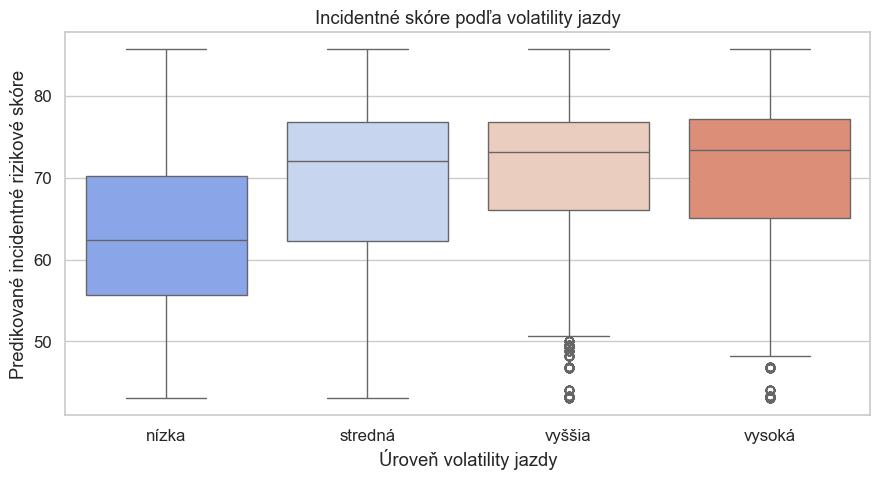

In [26]:
# Najprv vytvoríme kategórie volatility
df["volatility_group"] = pd.qcut(df["volatility"], q=4, labels=["nízka", "stredná", "vyššia", "vysoká"])

plt.figure(figsize=(9, 5))
sns.boxplot(data=df, x="volatility_group", y="predicted_incident_risk_score", palette="coolwarm")
plt.title("Incidentné skóre podľa volatility jazdy")
plt.xlabel("Úroveň volatility jazdy")
plt.ylabel("Predikované incidentné rizikové skóre")
plt.tight_layout()
plt.show()


C:\Users\Kristián\AppData\Local\Temp\ipykernel_33652\1107273579.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_filtered, x="hard_accels", y="predicted_incident_risk_score", palette="Set2")


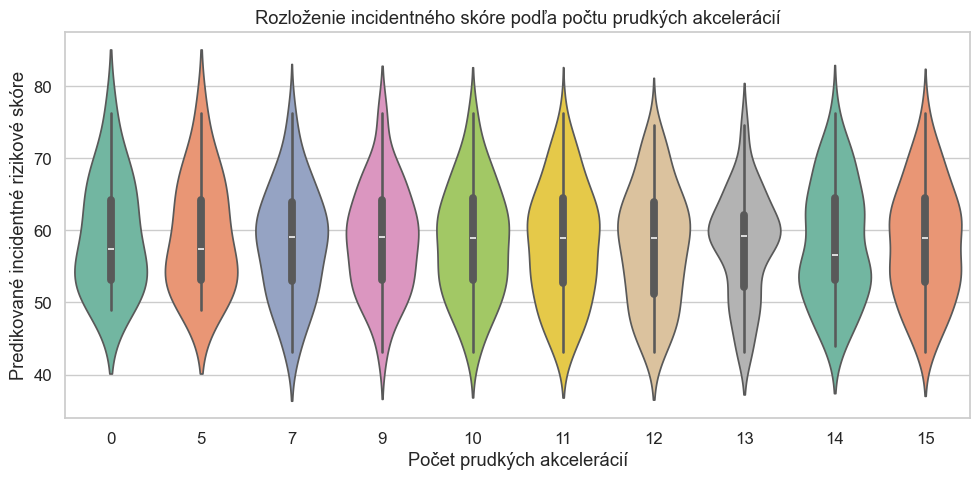

In [27]:
# Pre zrozumiteľnosť obmedzíme hodnoty na realistický rozsah
df_filtered = df[df["hard_accels"] <= 15]

plt.figure(figsize=(10, 5))
sns.violinplot(data=df_filtered, x="hard_accels", y="predicted_incident_risk_score", palette="Set2")
plt.title("Rozloženie incidentného skóre podľa počtu prudkých akcelerácií")
plt.xlabel("Počet prudkých akcelerácií")
plt.ylabel("Predikované incidentné rizikové skóre")
plt.tight_layout()
plt.show()


C:\Users\Kristián\AppData\Local\Temp\ipykernel_33652\146822075.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=df, x="day_of_week_name", y="predicted_incident_risk_score", estimator="mean", ci="sd", marker="o")


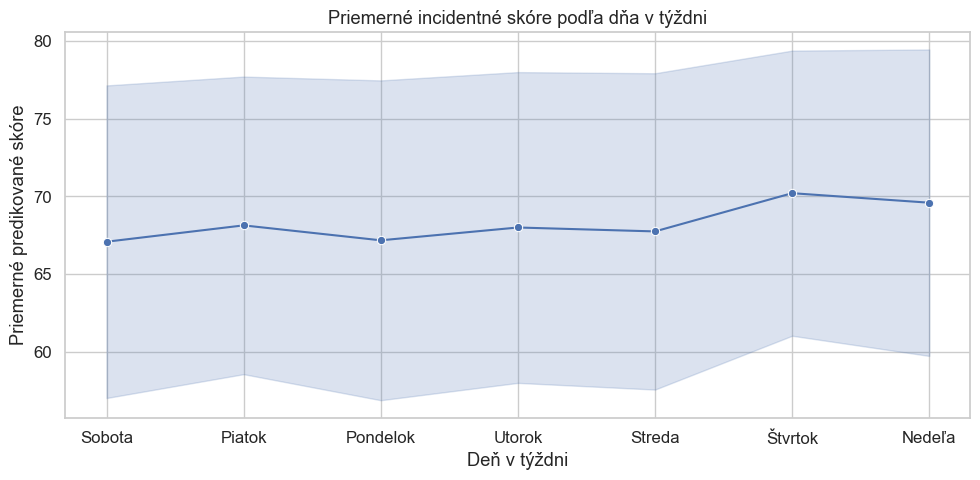

In [13]:
# Premenujeme si dni (ak sú číslované)
df["day_of_week_name"] = df["day_of_week"].map({
    0: "Pondelok", 1: "Utorok", 2: "Streda", 3: "Štvrtok",
    4: "Piatok", 5: "Sobota", 6: "Nedeľa"
})

plt.figure(figsize=(10, 5))
sns.lineplot(data=df, x="day_of_week_name", y="predicted_incident_risk_score", estimator="mean", ci="sd", marker="o")
plt.title("Priemerné incidentné skóre podľa dňa v týždni")
plt.xlabel("Deň v týždni")
plt.ylabel("Priemerné predikované skóre")
plt.tight_layout()
plt.show()


C:\Users\Kristián\AppData\Local\Temp\ipykernel_33652\1814657337.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="trip_category", y="predicted_incident_risk_score", palette="BuGn")


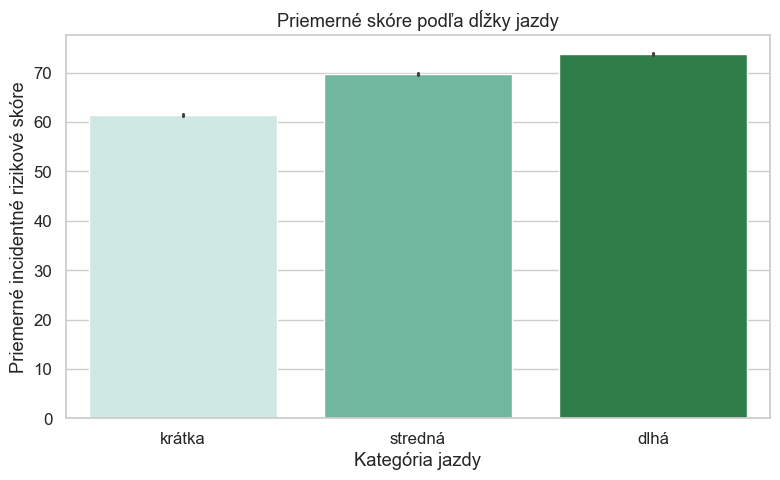

In [14]:
# Predpokladaná kategória (napr. krátka, stredná, dlhá trasa)
df["trip_category"] = pd.qcut(df["trip_duration_sec"], q=3, labels=["krátka", "stredná", "dlhá"])

plt.figure(figsize=(8, 5))
sns.barplot(data=df, x="trip_category", y="predicted_incident_risk_score", palette="BuGn")
plt.title("Priemerné skóre podľa dĺžky jazdy")
plt.xlabel("Kategória jazdy")
plt.ylabel("Priemerné incidentné rizikové skóre")
plt.tight_layout()
plt.show()


C:\Users\Kristián\AppData\Local\Temp\ipykernel_33652\1030775473.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=df, x="traffic", y="predicted_incident_risk_score", palette="viridis", estimator="mean", ci=None)
C:\Users\Kristián\AppData\Local\Temp\ipykernel_33652\1030775473.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df, x="traffic", y="predicted_incident_risk_score", palette="viridis", estimator="mean", ci=None)


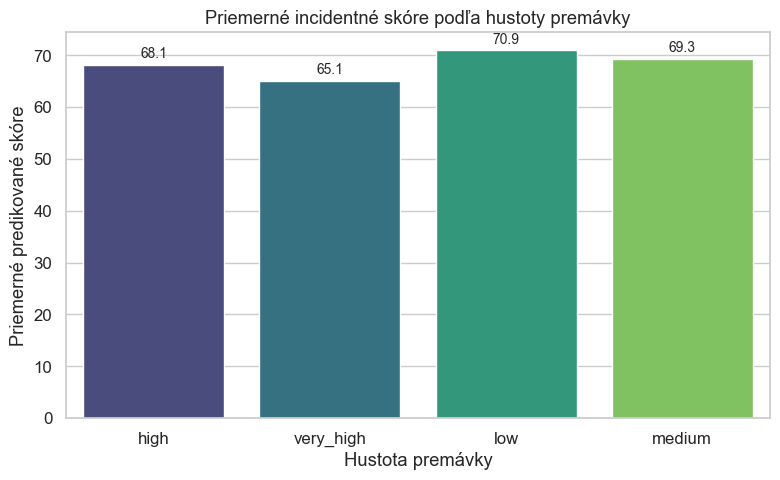

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
ax = sns.barplot(data=df, x="traffic", y="predicted_incident_risk_score", palette="viridis", estimator="mean", ci=None)
plt.title("Priemerné incidentné skóre podľa hustoty premávky")
plt.xlabel("Hustota premávky")
plt.ylabel("Priemerné predikované skóre")

# Pridanie hodnôt nad stĺpce
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f"{height:.1f}", xy=(p.get_x() + p.get_width() / 2, height),
                xytext=(0, 5), textcoords="offset points", ha="center", fontsize=10)

plt.tight_layout()
plt.show()


In [23]:
print(df.columns.tolist())


['ssoId', 'driverType', 'scenario', 'traffic', 'timestamp', 'hour', 'day_of_week', 'is_weekend', 'part_of_day', 'is_peak', 'is_night', 'weather_condition', 'road_state', 'temperature', 'visibility', 'precipitation', 'windspeed', 'avg_speed', 'max_speed', 'std_speed', 'volatility', 'overspeed_count', 'stops', 'hard_accels', 'hard_brakes', 'avg_jerk', 'std_accel', 'lateral_peak', 'direction_changes', 'fuel_drop', 'soc_drop', 'total_incidents', 'trip_duration_sec', 'distance_m', 'risk_score', 'incident_risk_score']


C:\Users\Kristián\AppData\Local\Temp\ipykernel_33652\3139993624.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="road_state", y="predicted_incident_risk_score", palette="Blues")


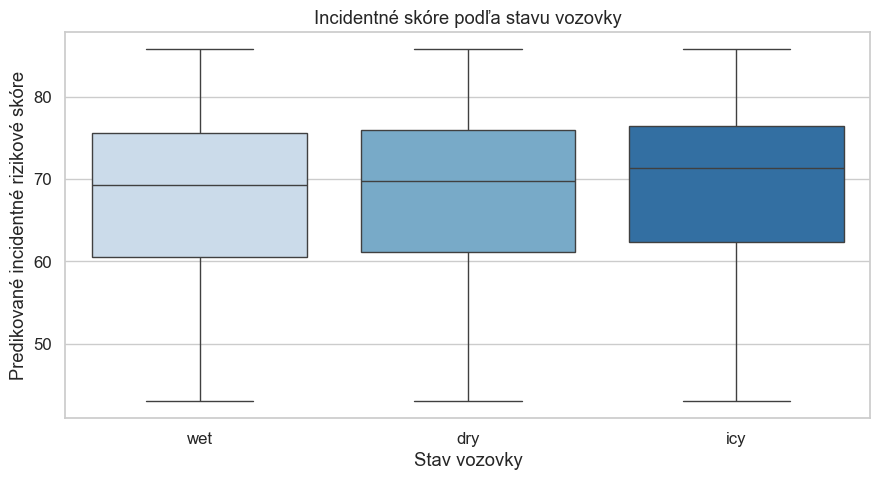

In [28]:
plt.figure(figsize=(9, 5))
sns.boxplot(data=df, x="road_state", y="predicted_incident_risk_score", palette="Blues")
plt.title("Incidentné skóre podľa stavu vozovky")
plt.xlabel("Stav vozovky")
plt.ylabel("Predikované incidentné rizikové skóre")
plt.tight_layout()
plt.show()


C:\Users\Kristián\AppData\Local\Temp\ipykernel_33652\208911414.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(
C:\Users\Kristián\AppData\Local\Temp\ipykernel_33652\208911414.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


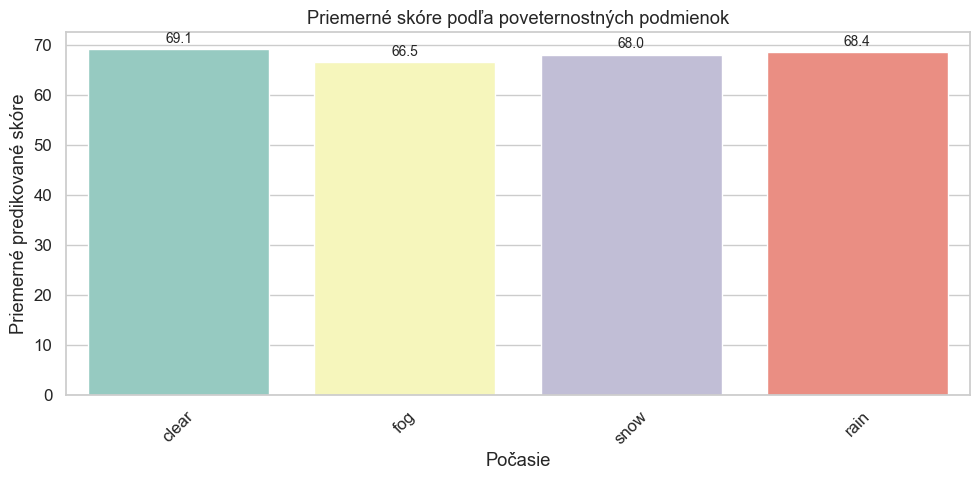

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
ax = sns.barplot(
    data=df,
    x="weather_condition",
    y="predicted_incident_risk_score",
    palette="Set3",
    estimator="mean",
    ci=None  # zruší zobrazenie čiernych čiar (chyby)
)

plt.title("Priemerné skóre podľa poveternostných podmienok")
plt.xlabel("Počasie")
plt.ylabel("Priemerné predikované skóre")
plt.xticks(rotation=45)

# Pridanie hodnôt nad stĺpce
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f"{height:.1f}", 
                xy=(p.get_x() + p.get_width() / 2, height),
                xytext=(0, 5), 
                textcoords="offset points",
                ha="center", fontsize=10)

plt.tight_layout()
plt.show()


C:\Users\Kristián\AppData\Local\Temp\ipykernel_33652\260321890.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x="scenario", y="predicted_incident_risk_score", palette="Accent")


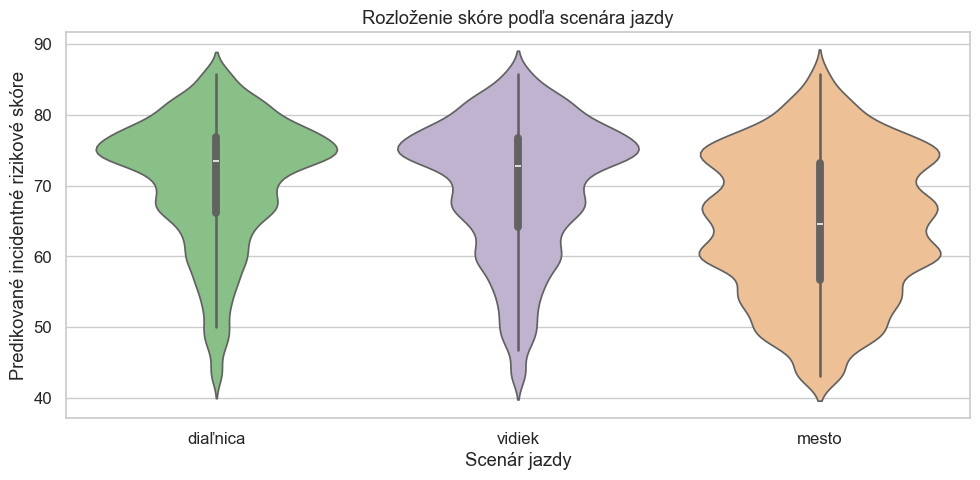

In [35]:
plt.figure(figsize=(10, 5))
sns.violinplot(data=df, x="scenario", y="predicted_incident_risk_score", palette="Accent")
plt.title("Rozloženie skóre podľa scenára jazdy")
plt.xlabel("Scenár jazdy")
plt.ylabel("Predikované incidentné rizikové skóre")
plt.tight_layout()
plt.show()
